In [29]:
import numpy as np
import pandas as pd

# Tamany de la mostra

Si llenço un dau 10 cops només, no tinc suficient informació per saber si el dau està trucat.

Però si el llenço 10.000 cops, i cada cara no surt aproximadament el mateix número de cops, llavors sí que puc dubtar del dau.

Conclusió: El tamany de la mostra IMPORTA.

In [30]:
# https://numpy.org/doc/stable/reference/random/index.html
# Valores Pseudo-aleatorios: Valores determistas cuyas propiedades
# se parecen a valores realmente aleatorios.

# RNG = Random Number Generator
rng = np.random.default_rng(12345)
rints = rng.integers(low=1, high=10, endpoint=True, size=100)
print(rints)
print(type(rints))
print(type(rints[0]))


[ 7  3  8  4  3  8  7  7 10  4  9  4  6  6  3  2  3  7  7 10  8  3 10 10
  8  7  2  1  3  5  1  9  5  7  3  4  2  8  8  3  8  1  4  2  8  4  5  5
  5  3  6  9  5  2  1  2  1  1  2  6  9  9  7  7  4 10  7  8  8  9  8 10
  6  6  3 10  6  5  4  3  7  5  6  7  9  4  7 10  5  3  3  4  7  3  9  4
  1  1  1  7]
<class 'numpy.ndarray'>
<class 'numpy.int64'>


# Estadística descriptiva

(Dades Covid19: https://dadescovid.cat/)

In [42]:
# Read data
covid_data: pd.DataFrame = pd.read_csv("2022-01-17-covid-dades-aga.csv", sep=';')

# Check columns
# covid_data.columns
# cols = ['INGRESSOS_TOTAL', 'INGRESSOS_CRITIC','INGRESSATS_TOTAL', 'INGRESSATS_CRITIC', 'EXITUS', 'CASOS_PCR', 'CASOS_TAR', 'POSITIVITAT_PCR_NUM', 'POSITIVITAT_TAR_NUM', 'POSITIVITAT_PCR_DEN', 'POSITIVITAT_TAR_DEN']

# Examine a subset of data
covid_data.loc[0:5, 'INGRESSOS_TOTAL':'POSITIVITAT_TAR_DEN']

,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS,CASOS_PCR,CASOS_TAR,POSITIVITAT_PCR_NUM,POSITIVITAT_TAR_NUM,POSITIVITAT_PCR_DEN,POSITIVITAT_TAR_DEN
0,0,0,0,0,0,0,9,0,5,0,7
1,0,0,0,0,0,0,1,0,0,0,2
2,0,0,1,0,0,0,3,0,1,0,1
3,0,0,1,0,0,0,6,0,1,0,2
4,0,0,0,0,0,0,8,0,3,0,7
5,0,0,0,0,0,0,8,0,3,0,4


            TAR_POSITIUS
DATA                    
2021-01-01             9
2021-01-02            19
2021-01-03            28
2021-01-04            92
2021-01-05            90


<AxesSubplot:xlabel='DATA'>

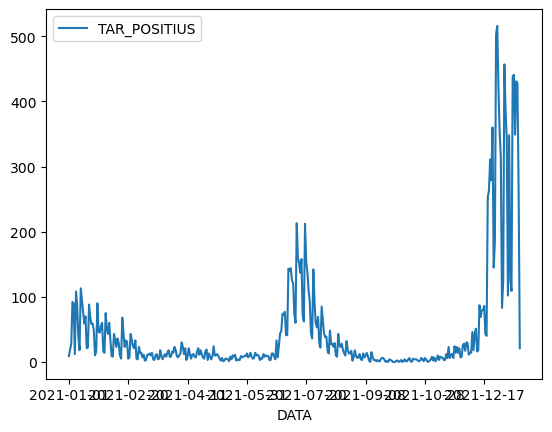

In [49]:
def get_year(epi_week: object) -> int:

    epi_week_str: str = str(epi_week)
    year_str:     str = epi_week_str[0:4]
    year_int:     int = int(year_str)

    return year_int

## replace L'HOSP ... per LHOSP
covid_data.loc[:,'NOM'] = covid_data.loc[:,'NOM'].str.replace("L'HOSP","LHOSP")

## Fixing step 4. Create Year colunm, assigning the first 4 characters of epi_week field.
covid_data.loc[:,'ANY'] = covid_data.loc[:,'DATA'].map(get_year)

lh_df1: pd.DataFrame = (covid_data.query("NOM == 'LHOSPITALET SUD I EL PRAT DE LLOBREGAT' ").query("ANY > 2020")
                                        .loc[:, ['DATA', 'POSITIVITAT_TAR_NUM']]
                                        .groupby('DATA')
                                        .sum()
                                        .rename(columns={"POSITIVITAT_TAR_NUM": "TAR_POSITIUS"})
)
print(lh_df1.head())
lh_df1.plot()

In [50]:
# Extract the data as a column. Needed for the next functions.
tar_positius: pd.Series = lh_df1.loc[:, 'TAR_POSITIUS']
tar_positius

DATA
2021-01-01      9
2021-01-02     19
2021-01-03     28
2021-01-04     92
2021-01-05     90
             ... 
2022-01-12    349
2022-01-13    431
2022-01-14    428
2022-01-15    266
2022-01-16     21
Name: TAR_POSITIUS, Length: 381, dtype: int64

In [51]:
# Mean
# Make sure input is a series.
# If input is a dataframe, it will return a series, not a float.

def get_mean(ser: pd.Series) -> float:
    return sum(ser) / len(ser)

# tar_positius.mean()
get_mean(tar_positius)

45.94750656167979

<AxesSubplot:ylabel='Frequency'>

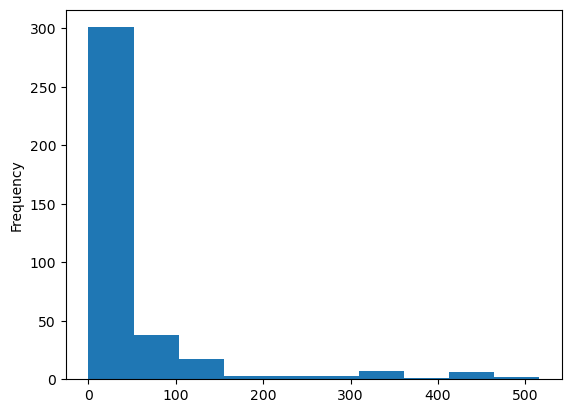

In [35]:
# Mode
# Mode = The value with the highest frequency.
# get_mode() returns the mode and its frequency.

def get_mode(ser: pd.Series) -> tuple[int, int]:

    # Make counter dictionary.
    # Keys:   Number of positives per day (without repeats)
    # Values: Frequencies of that number (zero initially)
    pos_freq_dict: dict[int, int] = dict.fromkeys(sorted(set(ser)), 0)

    # Calculate frequencies
    for num_pos in ser:
        pos_freq_dict[num_pos] += 1

    # Sort dictionary by values (frequencies)
    pos_freq_tuples:        list[tuple[int, int]] = pos_freq_dict.items()
    sorted_pos_freq_tuples: list[tuple[int, int]] = sorted(pos_freq_tuples,
                                                           key=lambda item: item[1],
                                                           reverse=True)
    mode_freq:              tuple[int, int]       = sorted_pos_freq_tuples[0]

    return mode_freq


# Mode = 0
# Frequency = 274
# tar_positius.mode()
get_mode(tar_positius)

# Using Panda's .value_counts()
freqs: pd.Series = tar_positius.value_counts()
mode:  int       = freqs.index[0]
freqs[mode]


# Histogram uses frequencies and bins.
# You can see it is not a normal distribution (normal bell)
tar_positius.plot.hist()



<AxesSubplot:xlabel='DATA'>

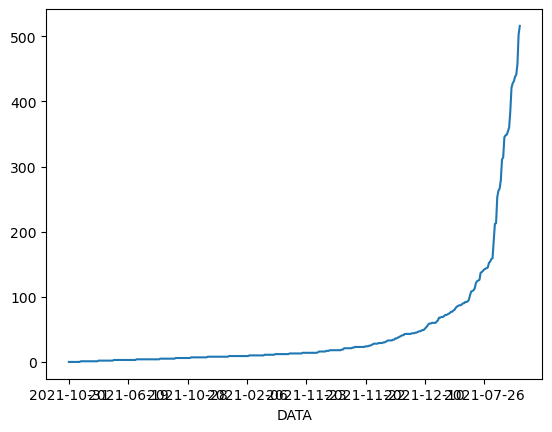

In [36]:
# Median
# If the length of ser is even, return the mean of the two central values.
# ~ Performs the bitwise negation. It's a Python trick.

def get_median(ser: pd.Series) -> float:

    sorted_data:  list[int] = sorted(ser)
    length:       int       = len(sorted_data)
    middle_index: int       = length // 2

    middle_value:          int   = sorted_data[middle_index]
    middle_value_from_end: int   = sorted_data[~middle_index]
    middle_mean:           float = (middle_value + middle_value_from_end) / 2

    return middle_mean

# tar_positius.sort_values()
tar_positius.sort_values().plot()
# tar_positius.median()
# get_median(tar_positius)

<AxesSubplot:>

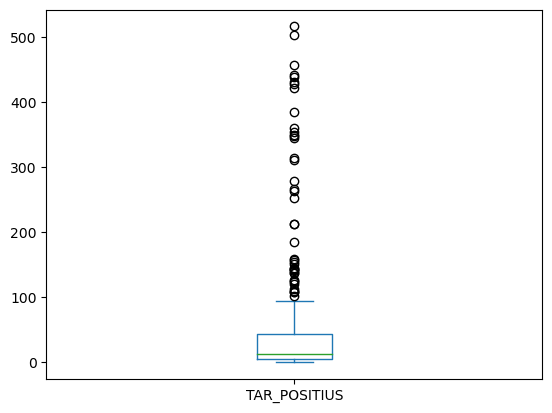

In [52]:
# Box Plot
# Useful for visualizing outliers.
# We cannot always remove outliers. Always think about their cause.
# https://statisticsbyjim.com/basics/remove-outliers/

tar_positius.plot.box()

In [38]:
# Desviación respecto a la media (v1)

mean: float       = tar_positius.mean()
devs: list[float] = []

for num_pos in tar_positius:
    devs.append(abs(num_pos - mean))

# Last ten deviations
devs[-10:]

[302.0524934383202,
 80.05249343832021,
 63.05249343832021,
 392.0524934383202,
 395.0524934383202,
 303.0524934383202,
 385.0524934383202,
 382.0524934383202,
 220.0524934383202,
 24.947506561679788]

In [39]:
# Desviación respecto a la media (v2 programación vectorial)
# Programación vectorial (array,list,vectores)
mean: float     = tar_positius.mean()
devs: pd.Series = (tar_positius - mean).abs()

devs
# devs.plot()

DATA
2021-01-01     36.947507
2021-01-02     26.947507
2021-01-03     17.947507
2021-01-04     46.052493
2021-01-05     44.052493
                 ...    
2022-01-12    303.052493
2022-01-13    385.052493
2022-01-14    382.052493
2022-01-15    220.052493
2022-01-16     24.947507
Name: TAR_POSITIUS, Length: 381, dtype: float64

#### Desviación típica

In [40]:
def typical_desviation(ser: pd.Series) -> float:

    suma:       int     =   ser.pow(2).sum()
    division:   float   =   suma/(devs.count() -1) #en estadística da mas similitud div por n-1
    desviacion: float   =   np.sqrt(division)
    return desviacion


result: float = typical_desviation(devs)
#porque puede variar un poco, por que en tecnica estadistica dof
print(result)

87.17391796879134


In [41]:
print(np.std(tar_positius))
print(tar_positius.std())

87.05944133638674
87.17391796879134
